# Forecasting carwash business insights

<b> Table of contents</b>
- Overview
- Setup
    - Get Authentication Token
- Make Query
    - Query Historical Data
        - Calculating past business insights
            - Classify the historical weather to different segments
        - Derive the historical average car washes
    - Query Forecast Weather Data
        - Understanding the output
        - Plot the Data
        - Calculating the forecast business insights
            - Classify the forecast weather to different segments
        - Utility function to calculate the total washes and staffing needs
        - Forecast business insights
- Plot the forecasted business insights
            - Plot daily washes and staff
            - Plot percentage car washes by weather condition
            - Visualize the revenue for each forecasted day calculated


## Overview

This notebook illustrates the usage of History on Demand HDAT and FDAT APIs to determine the business insights of a carwash business by using the historical sales' data of different weather conditions, and utilizing them to derive the business forecast for a period of 15 days starting from today.


## Setup

All of the documentation and samples we provide are built using Jupyter notebooks.

To run the notebooks, below are the basic requirements:

1. A Python3.7 or higher environment
2. A Jupyter Notebook environment
Note: The notebooks include runnable examples but you need to run them in order from top to bottom. This is because there are some lines of set up code, for example, setting authentication credentials, that only appear in the first code cell. We leave them out in the subsequent cells to avoid clutter.

To run this notebook seamlessly, you have to first configure your EI API credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your EI API key>
api.org_id = <Your EI Org Id>
api.tenant_id = <Your EI Tenant Id>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

Execute this notebook, cell after cell.

In [ ]:
%pip install configparser
%pip install pandas
%pip install requests
%pip install matplotlib

In [20]:
import requests
from pprint import pprint
import pandas as pd
import configparser
from io import StringIO
import json
from pandas import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import random
import numpy as np

#### Get Authentication Token

Now, we will set up the API Credentials as listed in below code and get an authentication token needed for us to be able to run and retrieve the data.

In [21]:
config = configparser.RawConfigParser()
config.read('../auth/secrets.ini')

# The below line is written so that the table's data won't get truncated.
pd.set_option('display.max_colwidth', None)

EI_API_KEY     = config.get('EI', 'api.api_key')
EI_ORG_ID      = config.get('EI', 'api.org_id') 
EI_TENANT_ID   = config.get('EI', 'api.tenant_id')

EI_AUTH_ENDPOINT = "https://api.ibm.com/saascore/run/authentication-retrieve"
EI_API_BASE_URL  = "https://api.ibm.com/geospatial/run/v3/wx"
EI_HDAT_ENDPOINT  = f"{EI_API_BASE_URL}/observations/historical/analytical/ext"
EI_FDAT_ENDPOINT = f"{EI_API_BASE_URL}/forecast/analytical/r2"

EI_AUTH_CLIENT_ID  = 'saascore-' + EI_TENANT_ID
EI_CLIENT_ID = 'geospatial-' + EI_TENANT_ID

auth_request_headers: dict = {}
auth_request_headers["X-IBM-Client-Id"] = EI_AUTH_CLIENT_ID
auth_request_headers["X-API-Key"] = EI_API_KEY

verify = True

auth_url = f"{EI_AUTH_ENDPOINT}/api-key?orgId={EI_ORG_ID}"
              
response = requests.get(url = auth_url,
                        headers = auth_request_headers,
                        verify  = verify
                       )
if response.status_code == 200:
    jwt_token = response.text
    print("Authentication Success")
else:     
    print("Authentication Failed")
    print(response.text)

Authentication Success


## Make Query

#### Query Historical Data

Once the API credentials are setup, we will build the required query parameters and headers for making an HDAT API call to retrieve the previous weather summary data for 6 months in 2023. 
With the query parameters and the headers setup, we will send an HTTP GET Request to the FDAT API Endpoint and get back the response.
This API response is a JSON structure which we'll convert to Dataframe and display.

There are various parameters you can send to retrieve the snowfall information for a particular location - 
1. either by using the geo coordinates or a postalKey of the desired location.
2. startDateTime and endDateTime for the location.
3. the required format for the output to be retrieved, in this case JSON and many other parameters required.


Now let's query for past data for the same area to understand past weather data and derive past business insights.

Let's take a zip code that we need to query for first. You can query for any zipcode provided in the format <i>zipCode:US</i>

In [22]:
zipCode = '57002:US' # Aurora, South Dakota
# zipCode = '62901:US' #Carbondale, Illinois

In [23]:
# Create the query parameter
# provide the geocode cordinates, startdatetime, enddatatime, format as json, units as per your requirements to get data

# get the start date - 1st of April 2023
start_date = '20230401'

# get the end date  - 30th of September 2023
end_date = '20230930'

query_params: dict = {}
query_params["postalKey"] = zipCode
query_params["startDate"] = start_date
query_params["endDate"] = end_date
query_params["format"] = "csv"
query_params["units"] = "s"
query_params["language"] = "en-US"

# Create the query headers
query_request_headers: dict = {}
query_request_headers["x-ibm-client-id"] = EI_CLIENT_ID
query_request_headers["Authorization"] = "Bearer " + jwt_token

# Create the Request object as GET Request with host URL, query parameters and query headers
request = requests.Request('GET', EI_HDAT_ENDPOINT, params=query_params, headers=query_request_headers)
 
# Create a Session object and send the request
session = requests.Session()
response = session.send(request.prepare())

if response.text != "":
    # Get the response as json
    csv_data = StringIO(response.text)
    historical_dataframe = pd.read_csv(csv_data)
    
    print("\n\n")
    pd.set_option('display.max_colwidth', None)
    display(historical_dataframe) 
else:
    print("Empty Response with status code: ", response.status_code)

,date,geoType,geoTypeId,latitude,longitude,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,20230401,postalKey,57002:US,44.285714,-96.679701,266.2,266.8,265.7,265.8,270.3,...,3.7,4.1,5.0,2.9,6.5,9.1,3.7,8.0,9.1,6.7
1,20230402,postalKey,57002:US,44.285714,-96.679701,273.2,273.3,272.9,271.6,273.3,...,2.0,6.7,7.4,5.9,2.6,3.5,2.0,2.4,2.8,2.0
2,20230403,postalKey,57002:US,44.285714,-96.679701,271.2,271.4,270.9,270.6,271.4,...,3.9,3.5,4.7,2.7,5.8,7.8,3.9,6.8,7.8,5.8
3,20230404,postalKey,57002:US,44.285714,-96.679701,271.5,271.7,271.2,270.7,271.9,...,3.1,8.9,10.2,7.4,4.9,7.4,3.1,5.9,7.4,3.3
4,20230405,postalKey,57002:US,44.285714,-96.679701,265.0,265.5,264.1,265.8,271.2,...,6.3,9.4,12.0,7.2,6.1,11.3,2.9,4.0,5.1,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,20230626,postalKey,57002:US,44.285714,-96.679701,283.7,285.1,282.5,285.4,287.5,...,0.2,5.5,6.3,4.7,0.5,1.5,0.0,0.2,1.0,0.0
87,20230627,postalKey,57002:US,44.285714,-96.679701,286.1,287.3,285.3,286.6,288.9,...,2.9,3.1,5.8,1.1,4.2,6.1,2.9,4.2,6.1,3.6
88,20230628,postalKey,57002:US,44.285714,-96.679701,290.0,290.7,289.5,289.6,291.1,...,0.4,5.3,5.9,4.4,1.3,3.9,0.1,0.6,1.2,0.1
89,20230629,postalKey,57002:US,44.285714,-96.679701,288.6,288.8,288.2,289.3,291.2,...,0.7,2.4,3.9,0.3,1.6,2.7,0.7,1.4,2.1,0.7


### Calculating past business insights

#### Classify the historical weather to different segments

Let's calculate your business insights for the past queried period.

But before we do that, we need to understand the local weather and how it is typically over the past days from the above data that we have received. Look at the below piece of code to understand the weather insights that says whether it's light/heavy snow/rainfall or no precipitation at all based on the factors Temperature, Precipitation, Relative Humidity, Dew Point, Snow Amount.

Look at the below piece of code to understand how different weather factors amount to different weather conditions.

In [24]:
historical_weather_df = pd.DataFrame(historical_dataframe)

# Function to determine if it will snow or rain and classify the intensity
def classify_weather(row):
    temp = row['TemperatureLocalDayAvg']
    precip = row['PrecipAmountLocalDayMax']
    rh = row['RelativeHumidityLocalDayAvg']
    dew_point = row['DewpointLocalDayAvg']
    snow_amount = row['SnowAmountLocalDayAvg']
    
    temp_celsius = temp - 273.15
    dew_point_celsius = dew_point - 273.15

    # Criteria for snowfall
    if temp_celsius <= 0 and precip > 0 and rh >= 70 and dew_point_celsius <= 0:
        if precip < 2.5:
            return "Light Snow"
        else:
            return "Heavy Snow"
    # Criteria for rainfall
    elif temp_celsius > 0 and precip > 0 and rh >= 70 and dew_point_celsius > 0:
        if precip < 2.5:
            return "Light Rain"
        else:
            return "Heavy Rain"
    # Direct detection from snow amount if available
    elif snow_amount > 0:
        if snow_amount < 2.5:
            return "Light Snow Detected in Data"
        else:
            return "Heavy Snow Detected in Data"
    else:
        return "No Precipitation"

historical_weather_df['HistoricalWeather'] = historical_weather_df.apply(classify_weather, axis=1)

print(historical_weather_df[['date', 'geoTypeId', 'HistoricalWeather']])


        date geoTypeId HistoricalWeather
0   20230401  57002:US        Light Snow
1   20230402  57002:US  No Precipitation
2   20230403  57002:US  No Precipitation
3   20230404  57002:US        Light Snow
4   20230405  57002:US  No Precipitation
..       ...       ...               ...
86  20230626  57002:US  No Precipitation
87  20230627  57002:US        Light Rain
88  20230628  57002:US        Light Rain
89  20230629  57002:US  No Precipitation
90  20230630  57002:US  No Precipitation

[91 rows x 3 columns]


#### Derive the historical average car washes

Now that we have classified the weather data, let's derive the average car washes for each type of day with past data we have.

As we don't have any past car wash data, we are going to assume some historical business insights as below. All these are average insights and may vary depnding on several other factors:

- If the weather condition is <i>Light snow</i>, we are going to have 2 to 20 car washes.
- Similarly, if the weather condition is <i>Heavy Snow</i>, we are going to have 2 to 6 car washes.
- If the weather condition is <i>Light Rain</i>, we are going to have 20 to 40 car washes.
- If the weather condition is <i>Heavy Rain</i>, we are going to have 50 to 90 car washes.
- On a <i>No Precipitation</i> day, which is the best day for our business, we can assume on an average 50 to 90 washes on that day.

Let's derive all the averages for each weather condition based on the above info.

Below is the piece of code that deals with all this information processing.

In [25]:
historical_start_date = pd.to_datetime(str(historical_weather_df.iloc[0]['date']), format='%Y%m%d')
historical_end_date = pd.to_datetime(str(historical_weather_df.iloc[-1]['date']), format='%Y%m%d')

historical_weather_data = historical_weather_df
date_list = []

while historical_start_date <= historical_end_date:
    date_list.append(int(historical_start_date.strftime('%Y%m%d')))
    historical_start_date += pd.Timedelta(days=1)

historical_sales_data = pd.DataFrame({
    'date': date_list
})

# Making up historical sales data based on weather conditions
historical_sales_list = []

for value in historical_weather_data['HistoricalWeather']:
    if value == 'Light Snow' or value == 'Light Snow Detected in Data':
        historical_sales_list.append(random.randint(2, 20))
    elif value == 'Heavy Snow' or value == 'Heavy Snow Detected in Data':
        historical_sales_list.append(random.randint(2, 6))
    elif value == 'Light Rain':
        historical_sales_list.append(random.randint(20, 40))
    elif value == 'Heavy Rain':
        historical_sales_list.append(random.randint(14, 20))
    else:
        historical_sales_list.append(random.randint(50, 90))

historical_sales_data['washes'] = historical_sales_list

historical_weather_data['date'] = pd.to_datetime(historical_weather_data['date'])
historical_sales_data['date'] = pd.to_datetime(historical_sales_data['date'])

data = pd.merge(historical_weather_data, historical_sales_data, on="date")

historical_average_washes = data.groupby('HistoricalWeather')['washes'].mean().astype(int)
print("\nAverage Washes per Weather Condition per day:")
print(historical_average_washes)


Average Washes per Weather Condition per day:
HistoricalWeather
Heavy Rain          16
Light Rain          29
Light Snow           6
No Precipitation    71
Name: washes, dtype: int64


#### Query Forecast Weather Data

Now let's query for forecast data for the same area to understand forecast weather data and derive future business insights.

In [26]:
# Create the query parameter
# provide the geocode cordinates, startdatetime, enddatatime, format as json, units as per your requirements to get data

# get the current date
current_date = (datetime.now()).strftime("%Y%m%d")

# get the forecast date
forecast_date = (datetime.now() + timedelta(days=15)).strftime("%Y%m%d")

query_params: dict = {}
query_params["postalKey"] = zipCode
query_params["startDate"] = current_date
query_params["endDate"] = forecast_date
query_params["format"] = "csv"
query_params["units"] = "e"
query_params["language"] = "en-US"

# Create the query headers
query_request_headers: dict = {}
query_request_headers["x-ibm-client-id"] = EI_CLIENT_ID
query_request_headers["Authorization"] = "Bearer " + jwt_token

# Create the Request object as GET Request with host URL, query parameters and query headers
request = requests.Request('GET', EI_FDAT_ENDPOINT, params=query_params, headers=query_request_headers)
 
# Create a Session object and send the request
session = requests.Session()
response = session.send(request.prepare())

if response.text != "":
    # Get csv  and convert to dataframe
    csv_data = StringIO(response.text)
    forecast_dataframe = pd.read_csv(csv_data)
    print("\n")
    pd.set_option('display.max_colwidth', None)
    display(forecast_dataframe) 
else:
    print("Empty Response with status code: ", response.status_code)

,date,postalKey,latitude,longitude,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,20241105,57002:US,44.289841,-96.673001,35.333333,36.0,35.0,35.458333,37.0,34.0,...,4.0,4.833333,5.0,4.0,3.916667,4.0,3.0,3.833333,4.0,3.0
1,20241106,57002:US,44.289841,-96.673001,35.166667,36.0,35.0,34.500000,38.0,32.0,...,3.0,3.833333,5.0,3.0,3.250000,4.0,3.0,3.166667,4.0,3.0
2,20241107,57002:US,44.289841,-96.673001,30.666667,31.0,30.0,31.333333,35.0,29.0,...,5.0,6.000000,9.0,3.0,4.916667,6.0,3.0,4.166667,5.0,3.0
3,20241108,57002:US,44.289841,-96.673001,36.333333,37.0,36.0,32.875000,37.0,27.0,...,6.0,6.333333,9.0,4.0,6.666667,7.0,6.0,6.833333,7.0,6.0
4,20241109,57002:US,44.289841,-96.673001,38.333333,39.0,38.0,37.750000,39.0,36.0,...,5.0,8.833333,10.0,7.0,5.916667,7.0,5.0,5.833333,6.0,5.0
5,20241110,57002:US,44.289841,-96.673001,39.333333,40.0,39.0,38.791667,40.0,37.0,...,6.0,8.333333,11.0,6.0,6.166667,7.0,6.0,6.333333,7.0,6.0
6,20241111,57002:US,44.289841,-96.673001,33.666667,34.0,33.0,33.583333,36.0,31.0,...,9.0,8.500000,11.0,6.0,9.583333,10.0,9.0,9.500000,10.0,9.0
7,20241112,57002:US,44.289841,-96.673001,38.000000,38.0,38.0,36.416667,38.0,34.0,...,10.0,13.500000,16.0,11.0,10.666667,12.0,10.0,11.000000,12.0,10.0
8,20241113,57002:US,44.289841,-96.673001,35.166667,36.0,34.0,34.500000,38.0,30.0,...,12.0,14.333333,16.0,12.0,11.666667,13.0,11.0,11.166667,12.0,11.0
9,20241114,57002:US,44.289841,-96.673001,28.000000,28.0,28.0,26.958333,29.0,24.0,...,8.0,13.166667,14.0,12.0,8.250000,9.0,8.0,8.500000,9.0,8.0


#### Understanding the output

If you look at the table above, it has information about various parameters that we deal with when we are reading the weather data such as min, max and avg values of dew point, wind speed, temperatures, precipitation, snowfall data etc.

We'll utilize some of these parameters in our calculations below to understand the weather while deriving the business insights.

NOTE: Depending on the time of the day that you're running this notebook which is relative to the postal code that you're querying, you might see information missing for a particular day part (beginning/1st day or end/15th day) if we don't have the whole data for it to provide an aggregate for that day part.

Now, let's plot a couple of graphs around the forecast weather data to look at the weather information visually and represent how various parameters such as Dewpoint, Temperature and snow amount varyy over the days.

#### Plot the Data

Let's plot various fields on the graph to understand how they relate to each other

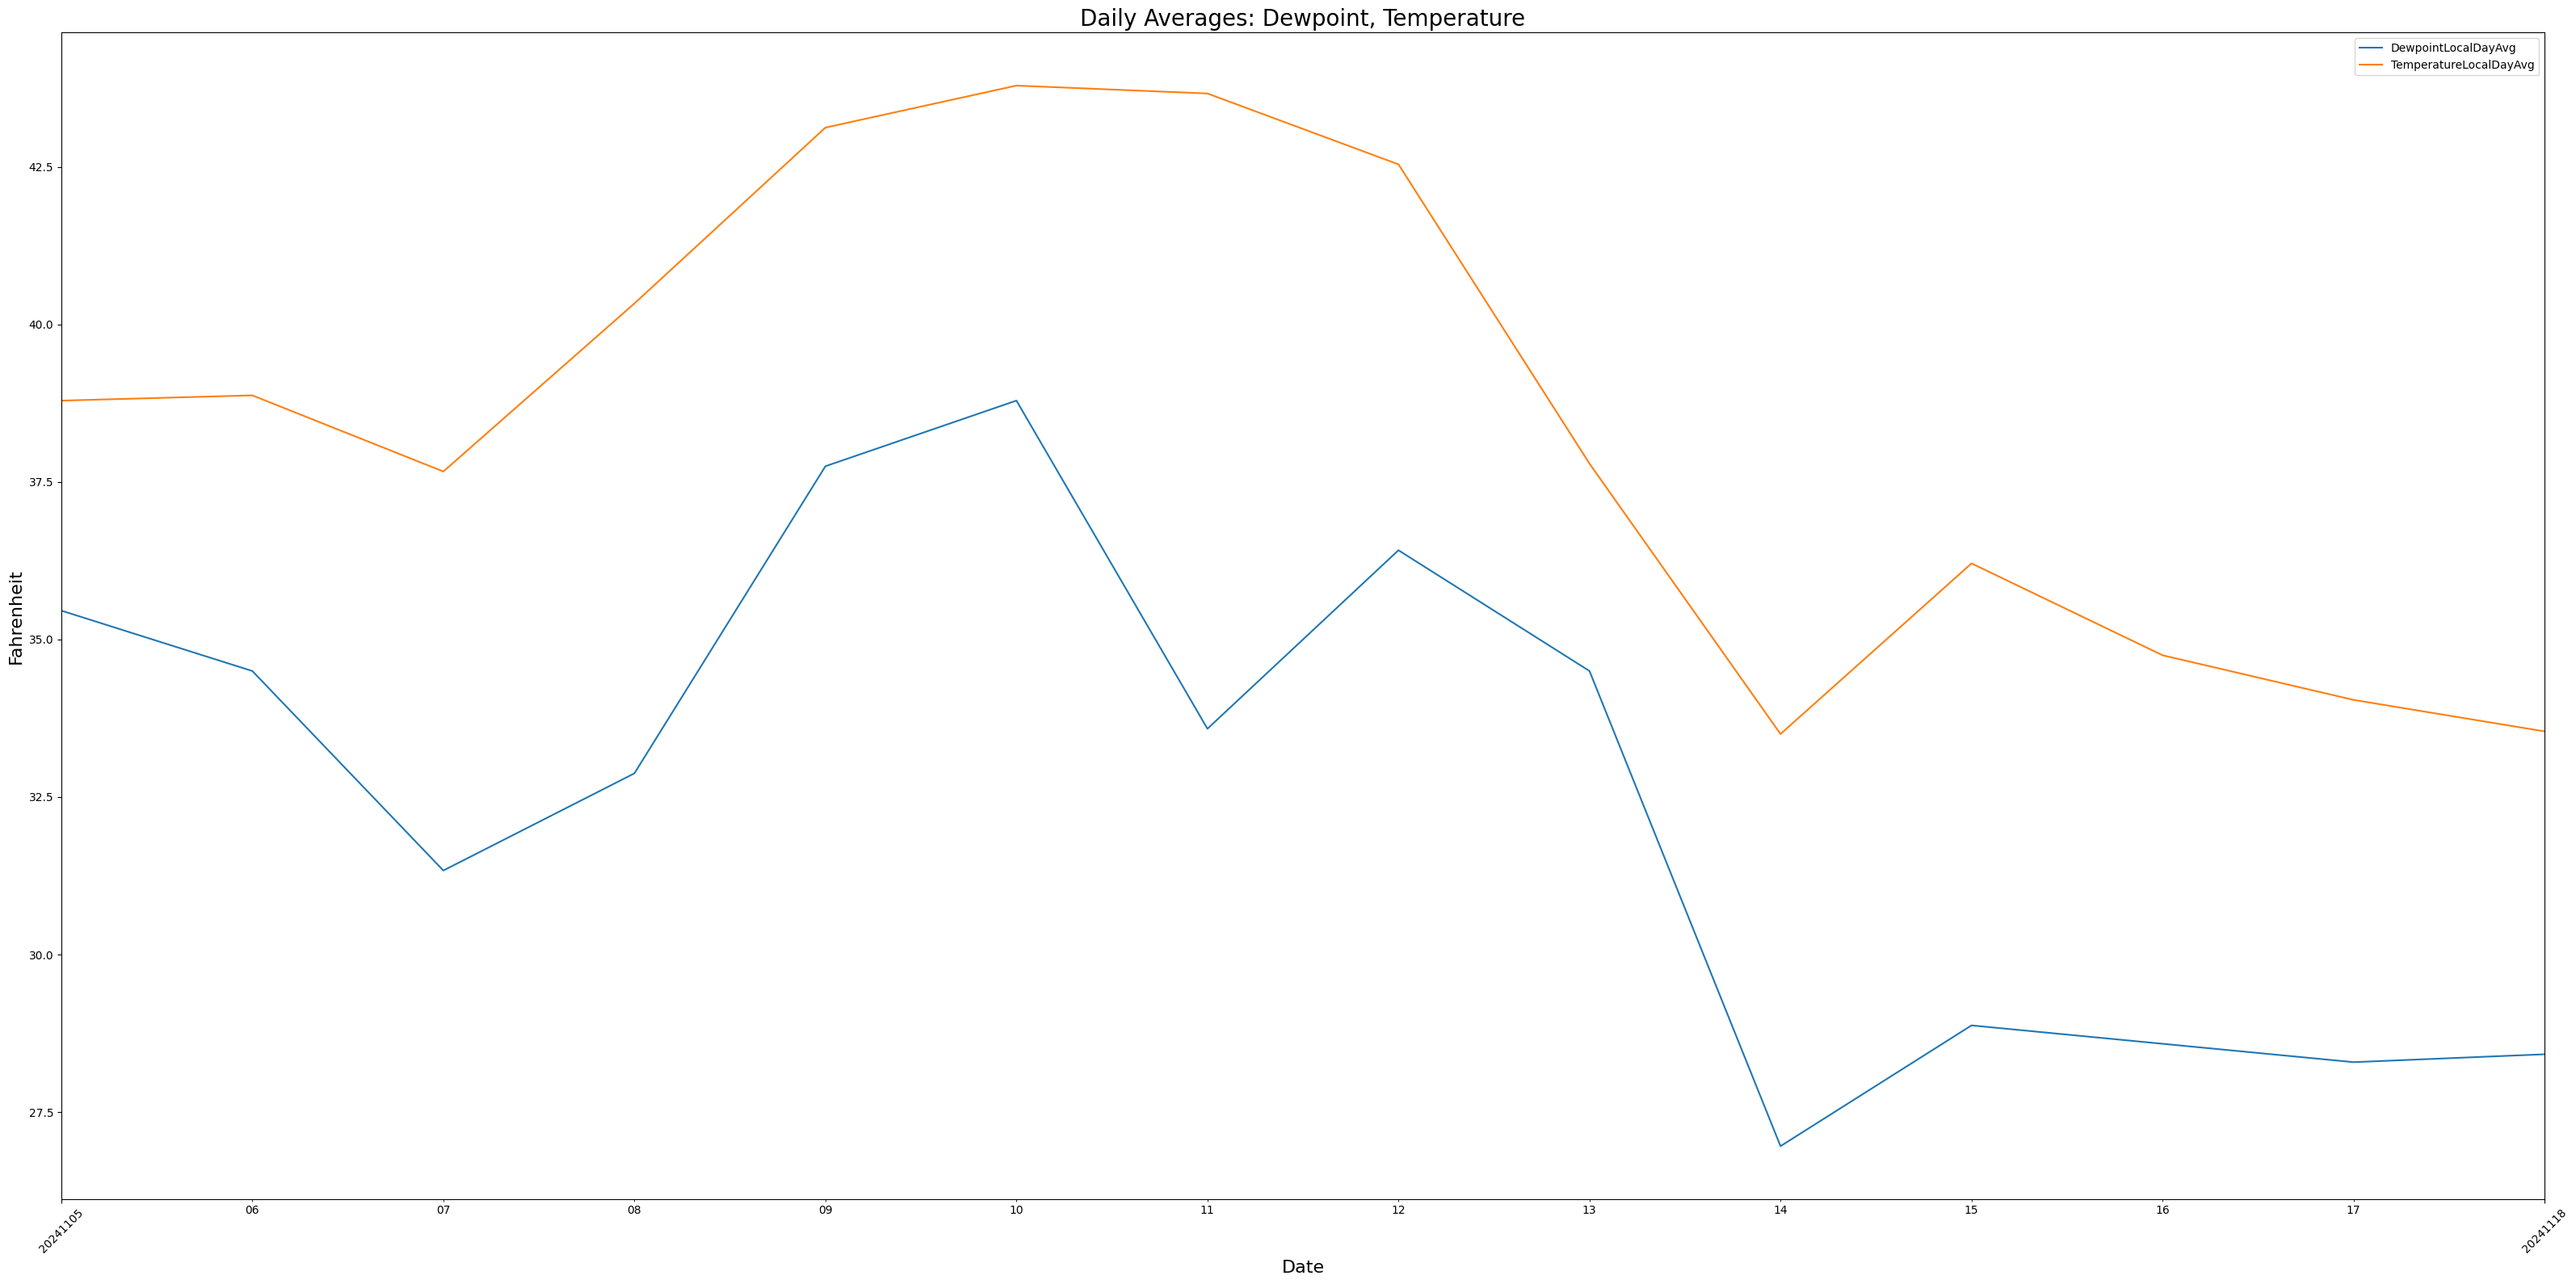

In [27]:
forecast_dataframe['date'] = pd.to_datetime(forecast_dataframe['date'], format='%Y%m%d')

fig, ax = plt.subplots(figsize=(32, 16))
forecast_dataframe.plot(
    x='date', 
    y=['DewpointLocalDayAvg', 'TemperatureLocalDayAvg'], 
    ax=ax
)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Fahrenheit', fontsize=16)
ax.set_title('Daily Averages: Dewpoint, Temperature', fontsize=20)

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.tight_layout()
plt.show()

As we know that if the dew point is higher, it leads to more humidity and dew/fog formation leading to lesser business during the day.

Let's understand the snowfall information for the next 15 days to see how it impacts us.

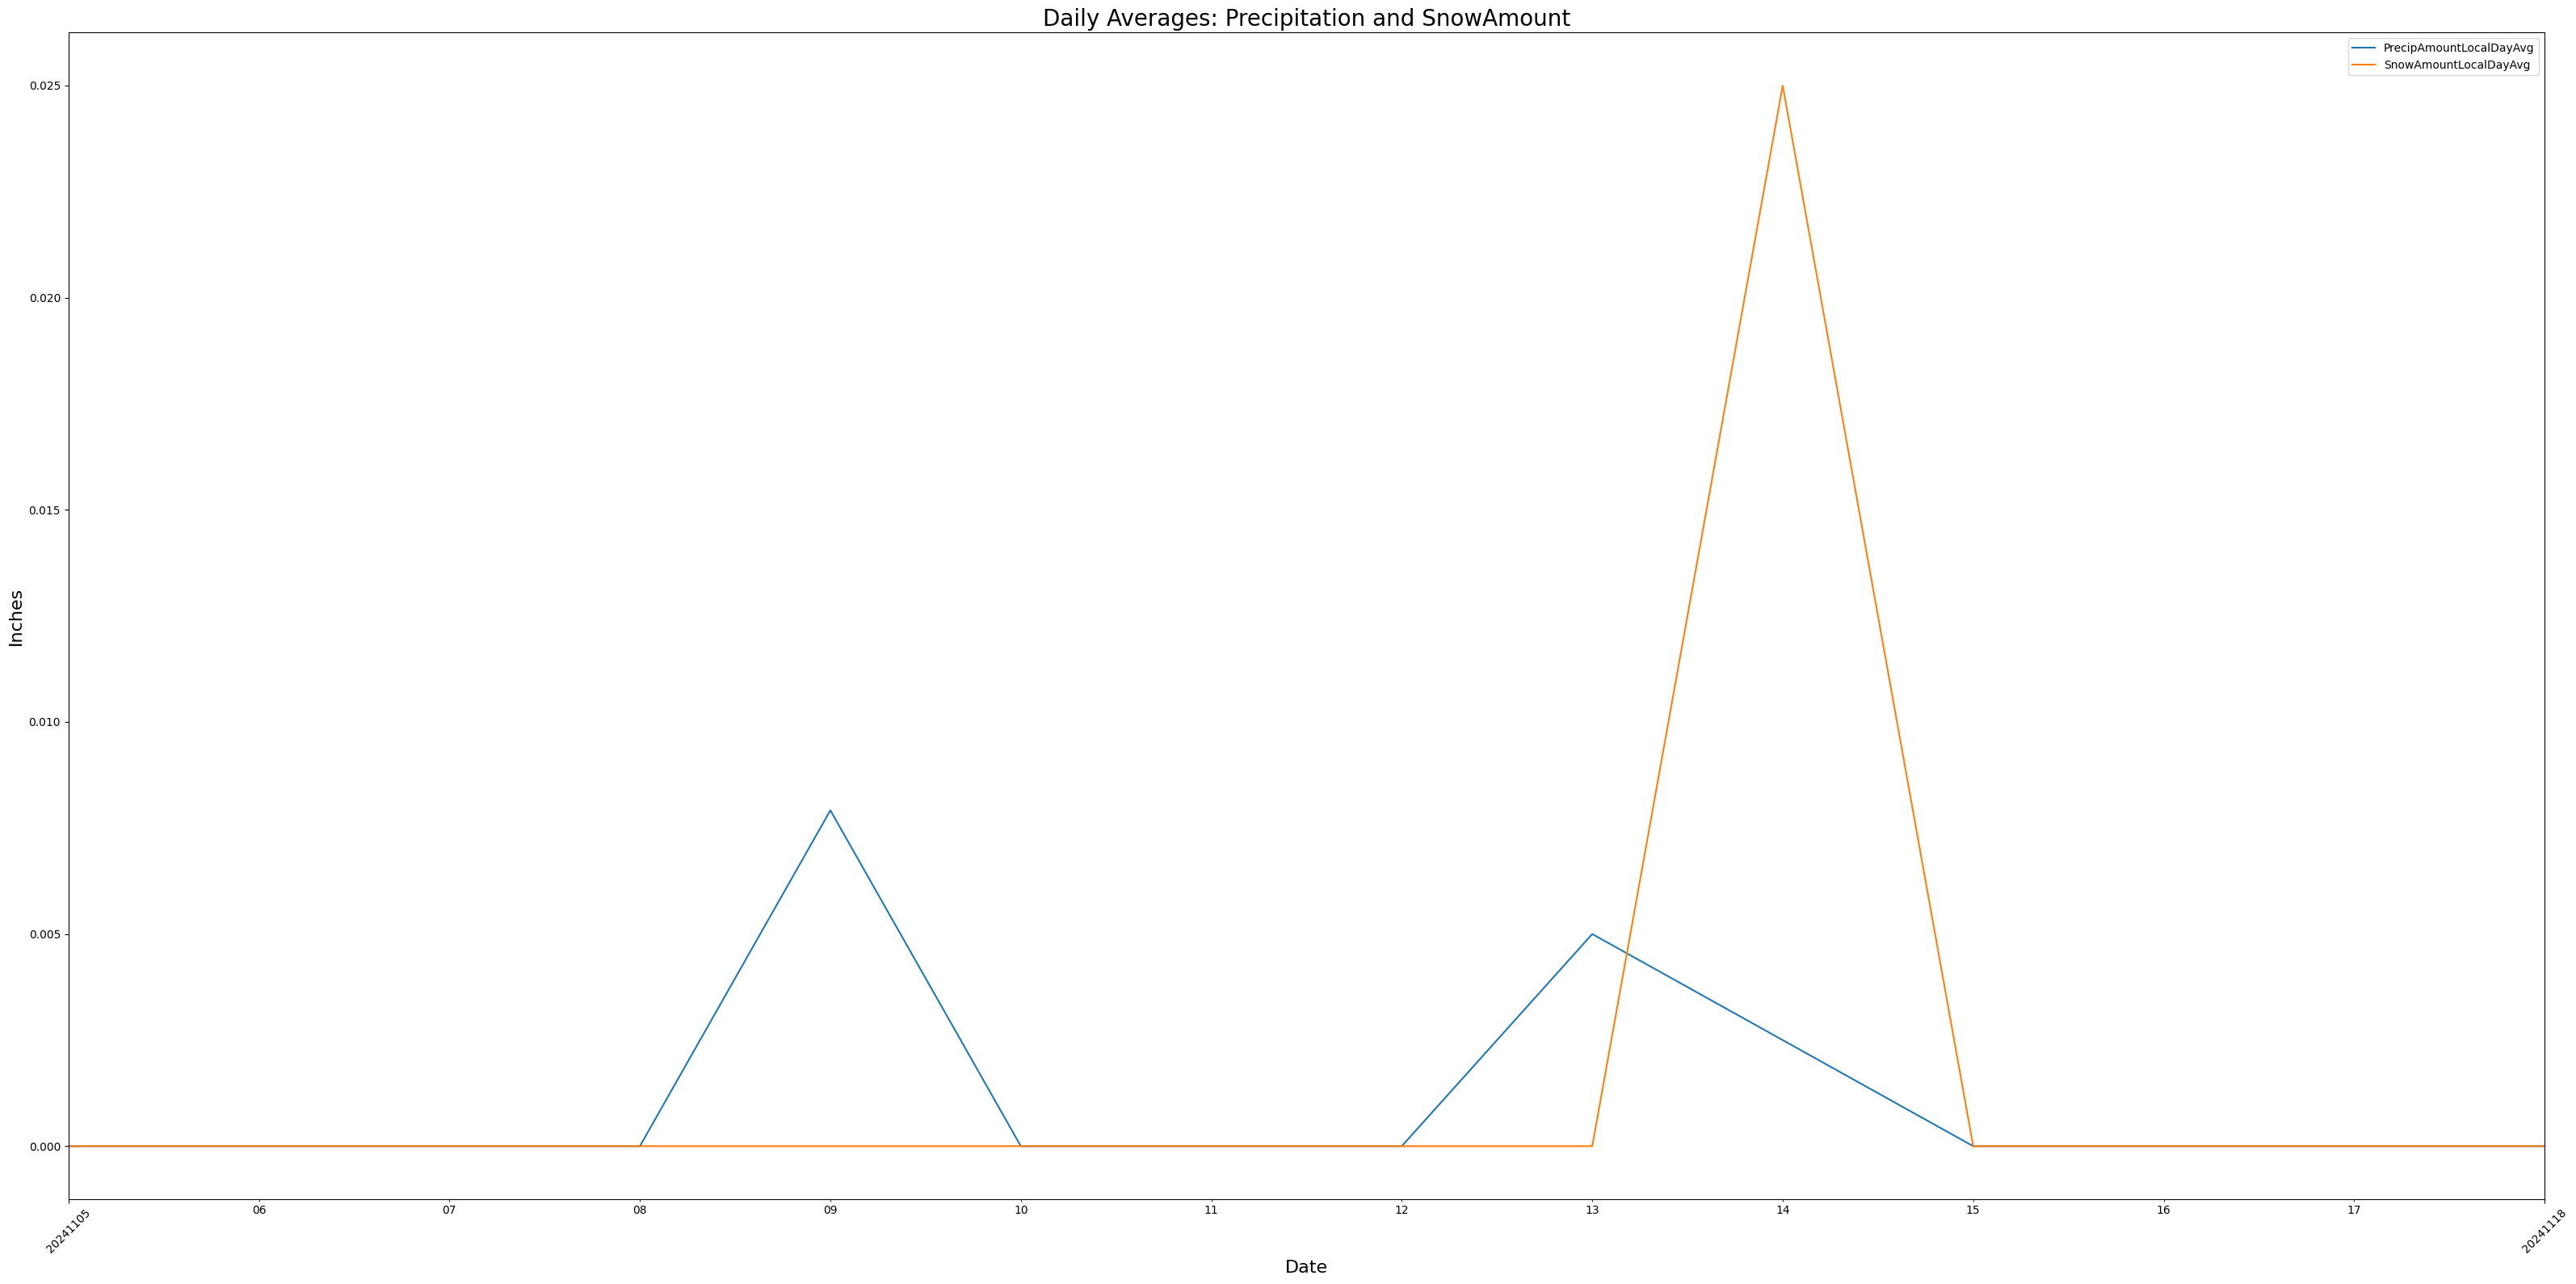

In [28]:
forecast_dataframe['date'] = pd.to_datetime(forecast_dataframe['date'], format='%Y%m%d')

fig, ax = plt.subplots(figsize=(32, 16))
forecast_dataframe.plot(
    x='date', 
    y=['PrecipAmountLocalDayAvg','SnowAmountLocalDayAvg'], 
    ax=ax
)

# Set x-axis label, y-axis label, and title
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Inches', fontsize=16)
ax.set_title('Daily Averages: Precipitation and SnowAmount', fontsize=20)

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.tight_layout()
plt.show()

### Calculating the forecast business insights

#### Classify the forecast weather to different segments

Let's calculate your business insights for the forecast period.

But before we do that, we need to understand the local weather and how it is typically over the days from the above forecast data that we have received. Look at the below piece of code to understand the weather insights that says whether it's light/heavy snow/rainfall or no precipitation at all based on the factors Temperature, Precipitation, Relative Humidity, Dew Point, Snow Amount and extract the information needed to a different dataframe for further calculations.

Look at the conditions we have taken into account to classify the weather forecast data into various conditions.

In [29]:
forecast_weather_df = pd.DataFrame(forecast_dataframe)
forecast_weather_df['WeatherPrediction'] = forecast_weather_df.apply(classify_weather, axis=1)

In [30]:
weather_prediction_dataframe = pd.DataFrame(forecast_weather_df[['date', 'postalKey', 'WeatherPrediction']])
print(weather_prediction_dataframe)

         date postalKey WeatherPrediction
0  2024-11-05  57002:US  No Precipitation
1  2024-11-06  57002:US  No Precipitation
2  2024-11-07  57002:US  No Precipitation
3  2024-11-08  57002:US  No Precipitation
4  2024-11-09  57002:US        Light Snow
5  2024-11-10  57002:US  No Precipitation
6  2024-11-11  57002:US  No Precipitation
7  2024-11-12  57002:US  No Precipitation
8  2024-11-13  57002:US        Light Snow
9  2024-11-14  57002:US        Light Snow
10 2024-11-15  57002:US  No Precipitation
11 2024-11-16  57002:US  No Precipitation
12 2024-11-17  57002:US  No Precipitation
13 2024-11-18  57002:US  No Precipitation


#### Utility function to calculate the total washes and staffing needs

Below is the piece of code that does various calculations such as daily staff needed and daily costs incurred for the car washes that we derived from the historical sales data. We are also going to derive the total number of car washes for a weather consdition and total staffing costs pertaining to a weather condition.

When doing the below calculations, we are going to assume a couple of things which are:

 - A staff when provided a job is capable of doing 20 washes on an average on any given day.
 - A staff memeber is going to charge $100 on any given day when employed.
 - The business is gonna charge $15 per a car that's washed.

We are going to define these parameters in the beloow cell for quick glance and you can customize all these values according to your business model.

In [31]:
# Customize these fields according to the business model.

staff_cost_per_day=100 # assuming an employee charges $100 per day
washes_per_staff=20 # Assuming an employee can wash 20 cars
cost_per_wash = 15 # Assuming each wash costs $15

In [32]:
def forecast_washes_and_staffing(forecast_df, washes_per_weather, washes_per_staff, staff_cost_per_day):
    total_washes = 0
    total_costs = 0
    staffing_needs = {}

    # Iterate over unique weather conditions in the DataFrame
    for condition in forecast_df['WeatherPrediction'].unique():
        days = forecast_df[forecast_df['WeatherPrediction'] == condition].shape[0]

        # Calculate total washes for this condition
        total_condition_washes = washes_per_weather.get(condition, 0) * days
        total_washes += total_condition_washes
        
        # Calculate daily washes, staff needed, and costs for each day
        daily_washes = []
        daily_staff = []
        daily_costs = []
        
        for _ in range(days):
            daily_wash = washes_per_weather.get(condition, 0)
            staff_needed = max(1, round(daily_wash / washes_per_staff))
            daily_cost = staff_needed * staff_cost_per_day
            
            daily_washes.append(daily_wash)
            daily_staff.append(staff_needed)
            daily_costs.append(daily_cost)
        
        # Calculate total cost for this condition
        total_condition_cost = sum(daily_costs)
        total_costs += total_condition_cost

        staffing_needs[condition] = {
            'days': days,
            'total_washes': total_condition_washes,
            'total_staff_needed': round(total_condition_washes / washes_per_staff),
            'daily_washes': daily_washes,
            'daily_staff': daily_staff,
            'daily_costs': daily_costs,
            'total_condition_cost': total_condition_cost
        }
    
    return total_washes, total_costs, staffing_needs

#### Forecast business insights

Now let's determine the business forecast of an ABC carwash company using the above data and previous sales data.

Considering a case where the previous weather data doesn't have a weather condition classified for a given zipCode, example Heavy snow and if we detect the same condition in the forecasted data, we might still need the historical business data for the same condition, hence taking up the same values for the missed weather conditions in the exact same way that we assumed earlier.

In [33]:
weather_forecast = forecast_weather_df['WeatherPrediction'].value_counts().to_dict()

print("Weather Forecast (Days Count):")
print(weather_forecast, '\n')

# We are appending the data for any missing weather condition to give better insights
for condition, days in weather_forecast.items():
    if condition not in historical_average_washes.index.unique():
        # Assign average wash values based on weather condition type
        if condition == 'Light Snow' or condition == 'Light Snow Detected in Data':
            historical_average_washes[condition] = random.randint(2, 10)
        elif condition == 'Heavy Snow' or condition == 'Heavy Snow Detected in Data':
            historical_average_washes[condition] = random.randint(2, 6)
        elif condition == 'Light Rain':
            historical_average_washes[condition] = random.randint(20, 40)
        elif condition == 'Heavy Rain':
            historical_average_washes[condition] = random.randint(14, 20)
        else:
            historical_average_washes[condition] = random.randint(50, 90)


total_washes, total_costs, staffing_plan = forecast_washes_and_staffing(weather_prediction_dataframe, historical_average_washes, washes_per_staff, staff_cost_per_day)

print("\nForecasted Washes, Staffing Needs, and Costs:")
print(f"Total Estimated Washes: {total_washes}")
print(f"Total Estimated Staff Costs: ${total_costs}")

for condition, details in staffing_plan.items():
    print(f"\n{details['days']} days of {condition}:")
    print(f"  Total Estimated average Washes: {details['total_washes']}")
    print(f"  Total Staff Needed: {details['total_staff_needed']}")
    print(f"  Total Condition Cost: ${details['total_condition_cost']}\n")
    
    for i, (wash, staff, cost) in enumerate(zip(details['daily_washes'], details['daily_staff'], details['daily_costs']), 1):
        print(f"    Day {i}: Estimated average Washes = {wash}, Staff Needed = {staff}, Staff Cost = ${cost}")

# Estimate revenue
estimated_revenue = total_washes * cost_per_wash
print(f"\nEstimated Revenue: ${estimated_revenue}")

Weather Forecast (Days Count):
{'No Precipitation': 11, 'Light Snow': 3} 


Forecasted Washes, Staffing Needs, and Costs:
Total Estimated Washes: 799
Total Estimated Staff Costs: $4700

11 days of No Precipitation:
  Total Estimated average Washes: 781
  Total Staff Needed: 39
  Total Condition Cost: $4400

    Day 1: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 2: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 3: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 4: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 5: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 6: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 7: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 8: Estimated average Washes = 71, Staff Needed = 4, Staff Cost = $400
    Day 9: Estimated average Washes = 71, Staff Needed = 4, Staff C

If you look at the above data that's being displayed, we have successfully calculated the number of car washes on different weather conditioned days and adjusted the staff as needed for each weather day and the total staff needed for all the classified weather days. You can utilize this and adjust your staffing accordingly so that you get maximum revenue.

## Plot the forecasted business insights

Let's look at the same data using different plots for better visualization of the derived insights.

#### 1. Plot daily washes and staff

Let's understand the relation between the number of car washes and the staff needed to accommodate all the washes.

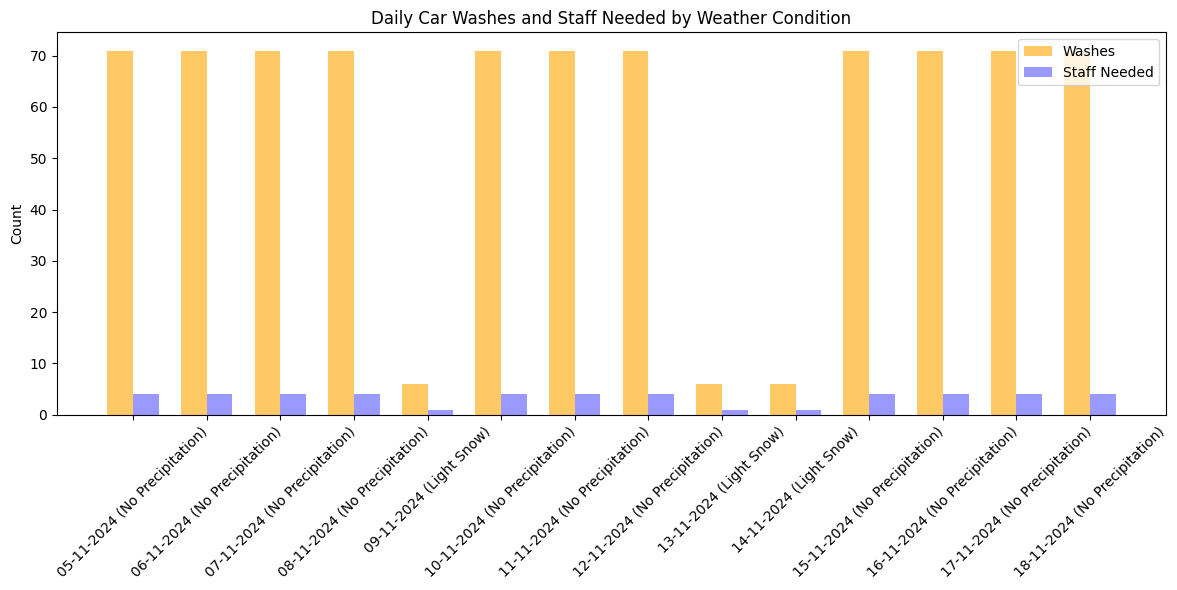

In [34]:
def plot_daily_washes_and_staff(df):
    daily_data = []
    
    # Create staffing plan based on the forecast DataFrame
    for index, row in df.iterrows():
        condition = row['WeatherPrediction']
        washes = historical_average_washes.get(condition, 0)
        staff_needed = max(1, round(washes / 20))  # Assuming 20 washes per staff
        
        daily_data.append({
            'Day': pd.to_datetime(row['date']).strftime('%d-%m-%Y'),  # Format date to dd-mm-yyyy
            'Washes': washes,
            'Staff Needed': staff_needed,
            'Weather Condition': condition
        })

    df_daily = pd.DataFrame(daily_data)

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(df_daily))

    # Bars for washes and staff needed
    plt.bar(index, df_daily['Washes'], width=bar_width, label='Washes', color='orange', alpha=0.6)
    plt.bar([i + bar_width for i in index], df_daily['Staff Needed'], width=bar_width, label='Staff Needed', color='blue', alpha=0.4)

    plt.ylabel('Count')
    plt.title('Daily Car Washes and Staff Needed by Weather Condition')
    plt.xticks([i + bar_width / 2 for i in index], [f"{df_daily['Day'][i]} ({df_daily['Weather Condition'][i]})" for i in index], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_daily_washes_and_staff(weather_prediction_dataframe)

#### 2. Plot percentage car washes by weather condition

Let's understand the percentage of business happened on each weather condition in a pie chart.

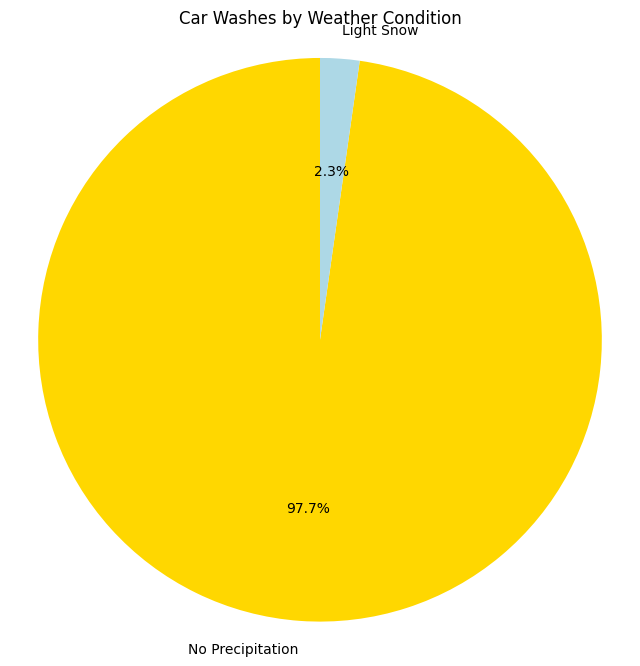

In [35]:
def plot_car_washes_by_condition(staffing_plan):
    total_washes_by_condition = {condition: details['total_washes'] for condition, details in staffing_plan.items()}

    plt.figure(figsize=(8, 8))
    plt.pie(total_washes_by_condition.values(), 
            labels=total_washes_by_condition.keys(), 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=['gold', 'lightblue', 'lightgreen', 'orange', 'blue'])
    plt.title('Car Washes by Weather Condition')
    plt.axis('equal')
    plt.show()

plot_car_washes_by_condition(staffing_plan)


#### 3. Visualize the revenue for each forecasted day calculated

Let's understand how the revenue varies according to the change in weather conditions and how it affects the business.

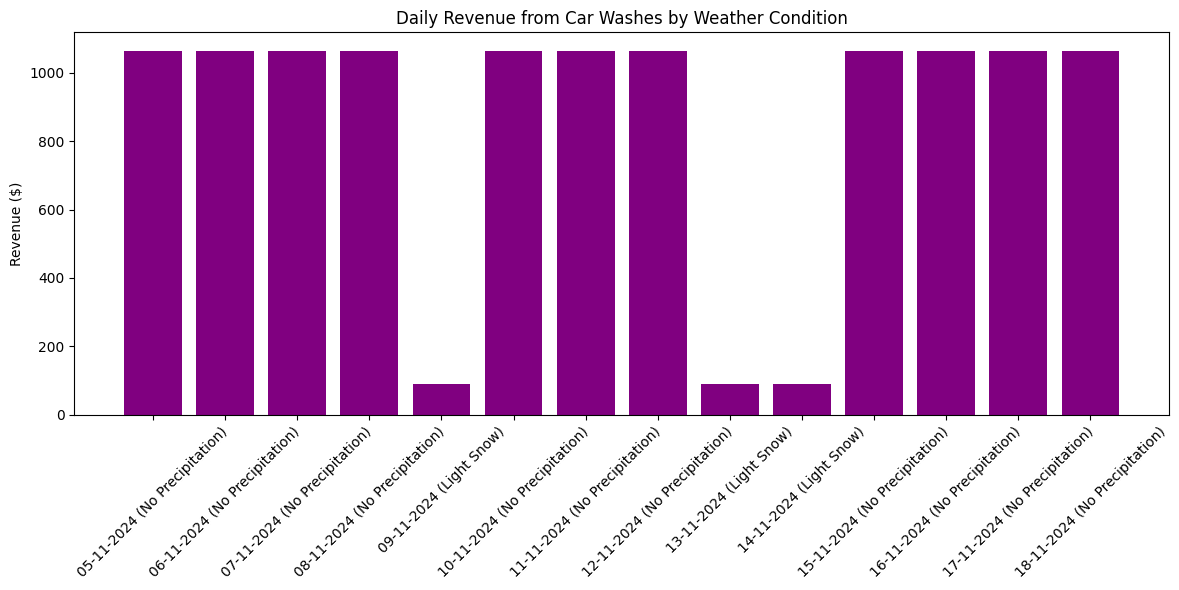

In [36]:
def plot_daily_revenue(df, cost_per_wash=15):
    daily_data = []

    # Create revenue data based on the forecast DataFrame
    for index, row in df.iterrows():
        condition = row['WeatherPrediction']
        washes = historical_average_washes.get(condition, 0)
        revenue = washes * cost_per_wash
        
        daily_data.append({
            'Day': pd.to_datetime(row['date']).strftime('%d-%m-%Y'),
            'Revenue': revenue,
            'Weather Condition': condition
        })

    df_daily_revenue = pd.DataFrame(daily_data)

    plt.figure(figsize=(12, 6))
    plt.bar(df_daily_revenue['Day'], df_daily_revenue['Revenue'], color='purple')
    plt.ylabel('Revenue ($)')
    plt.title('Daily Revenue from Car Washes by Weather Condition')
    plt.xticks(rotation=45)

    # Adding weather conditions in the x-tick labels
    plt.xticks([i for i in range(len(df_daily_revenue))], 
               [f"{df_daily_revenue['Day'][i]} ({df_daily_revenue['Weather Condition'][i]})" for i in range(len(df_daily_revenue))],
               rotation=45)

    plt.tight_layout()
    plt.show()

plot_daily_revenue(weather_prediction_dataframe)
